# Text Analysis

This notebook focuses on analyzing textual data from interviews.

- **Word Count Analysis:**  
   A quantitative measure that examines the verbosity of interviews to understand participant responses and interviewer engagement across experiments and conditions.

- **Interviewer Distributions:**  
   Exploring the distribution of interviewers and their contribution across interviews

- **Keyword Analysis:**
A qualitative deep dive into the language used during interviews:
   - **Preprocessing:** Preparing the text for meaningful analysis through cleaning, lowercasing, lemmatization, and stop-word removal.  
   - **Word Frequency:** Identifying frequently used terms and their distributions across participants, experiments, and conditions.  
   - **Unique Words:** Highlighting terms shared among participants to uncover common themes and differences across groups.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils.analysis_helpers import *

## Choose the data to analyse

- **Merge Transcripts:** Combine individual transcript files into a single dataset for analysis.
- **Filter Conditions:** Exclude non-relevant conditions (e.g., setup phase or small talk).
- **Differentiate Speakers:** Analyze data based on the roles (*Participant* or *Interviewer*).

In [3]:
directory = '../Dataset/meditation_interviews/transcripts_per_interview/csv/**/' 

df_all = load_and_combine_csv(directory)
df_all = standardize_speaker_labels(df_all)
df_all['Word Count'] = df_all['Content'].apply(lambda x: len(x.split()))

df_all.to_csv("outputs/transcripts_merged.csv", index=False)

Found 82 CSV files.


In [4]:
print(f"Unique conditions before filtering: {df_all['Condition'].unique()}")
print(f"Number of interviews before filtering: {df_all['File Name'].nunique()}")
# Remove rows with Condition == 0 (e.g., setup phase or small talk)
df_all = df_all[df_all["Condition"] != 0]
print(f"Unique conditions after filtering: {df_all['Condition'].unique()}")
print(f"Number of interviews (File Name) after filtering: {df_all['File Name'].nunique()}")

Unique conditions before filtering: [1 'C' 'I' 0]
Number of interviews before filtering: 82
Unique conditions after filtering: [1 'C' 'I']
Number of interviews (File Name) after filtering: 75


In [5]:
# If we only want to focus only on the Participant or Interviewer speaker
df_participant = df_all[df_all["Speaker"] == "Participant"].copy()
df_interviewer = df_all[df_all["Speaker"] == "Interviewer"].copy()

# Word Count

Word count analysis provides insights into the length and verbosity of interviews, offering a quantitative overview of the data. It helps in identifying patterns in participant responses and interviewer engagement across experiments or conditions.

Word count analysis serves as a foundational metric to explore further qualitative patterns, providing a baseline for understanding the dataset’s structure and variability.

## Word Count by Experiment

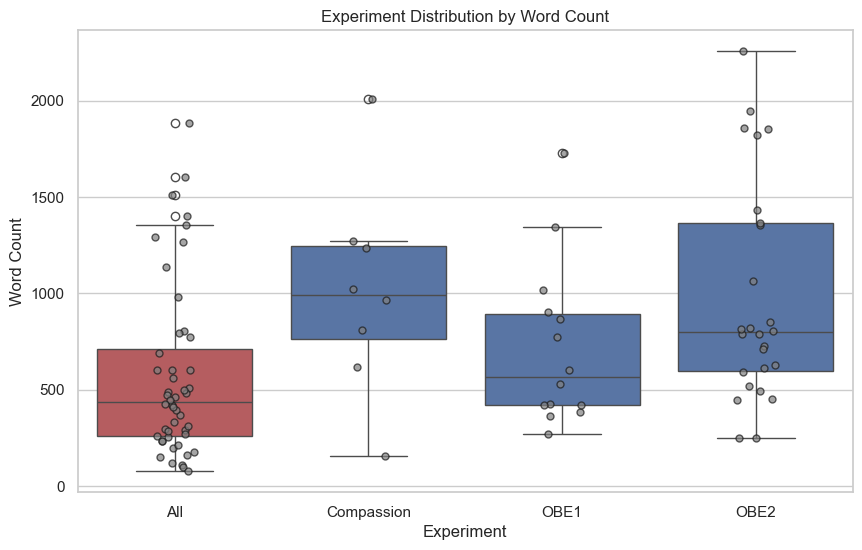

In [6]:
df_word = aggregate_counts(df_participant,["Experiment","Id"]).copy()
df_word['Experiment'] = 'All'

# Concatenate the original data with the "All" data
df_combined = pd.concat([df_word,aggregate_counts(df_all,["Experiment","Id"])])
default_palette = sns.color_palette("deep")  
palette = {experiment: (default_palette[0] if experiment != 'All' else default_palette[3]) for experiment in df_combined['Experiment'].unique()}

stripplot(df_combined, 'Experiment', 'Word Count', palette=palette)

## Word Count by Condition

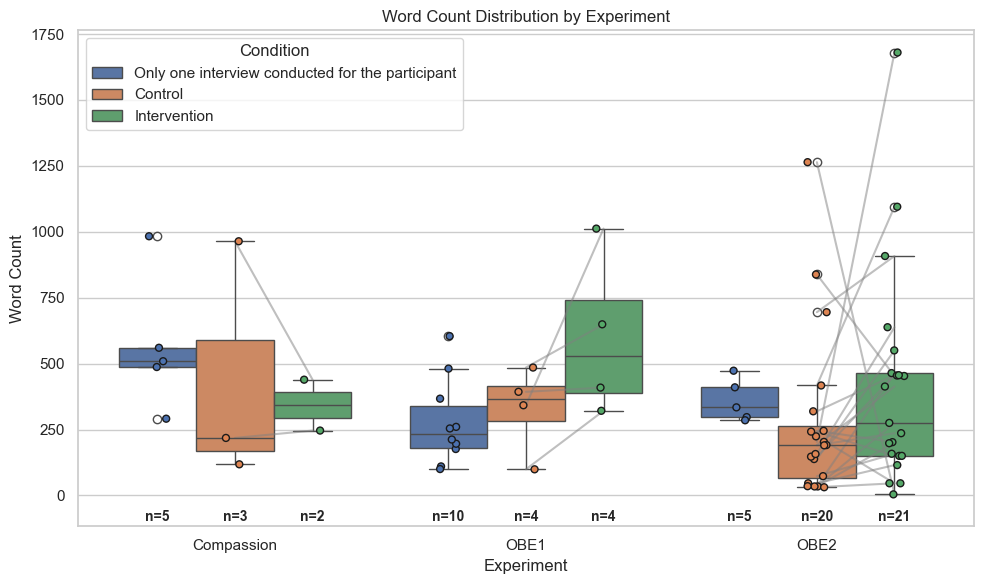

In [7]:
# Group by Id instead of File Name because the same participant can have the same condition in different interviews
stripplot_with_counts(aggregate_counts(df_participant, ['Experiment', "Id", "Condition"]), 'Experiment', 'Word Count', 
                      hue_column='Condition', id_column="Id", legend_labels=["Only one interview conducted for the participant","Control","Intervention"] ,file_name="images/conditions_distribution.png")

## Word Count by Experiment

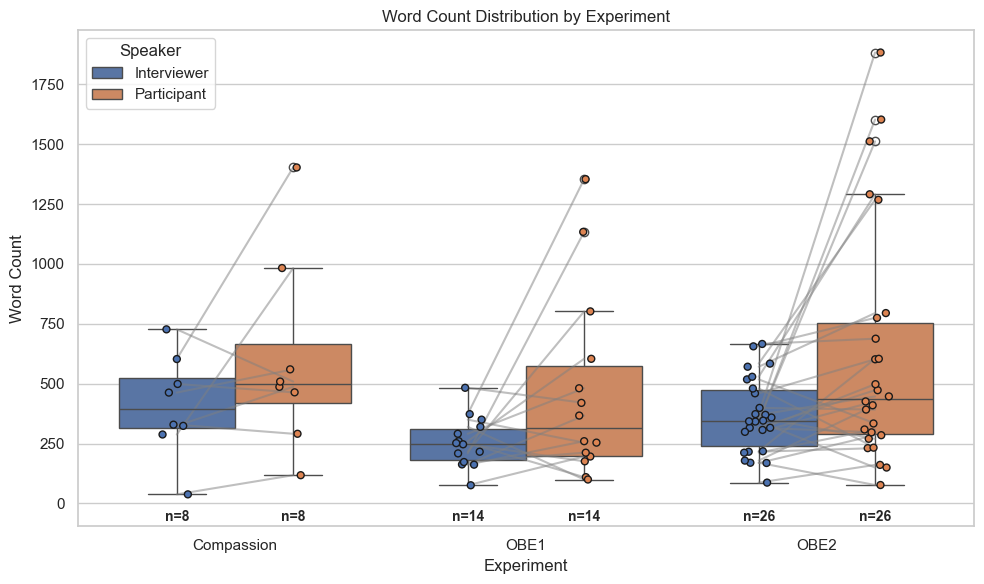

In [8]:
stripplot_with_counts(aggregate_counts(df_all, ['Experiment', "Id", 'Speaker']), 'Experiment', 'Word Count', hue_column='Speaker', id_column="Id")

# Interviewer Distribution

This analysis focuses on the distribution of interviewers across experiments and interviews. It examines the number of unique interviewers per interview and highlights variations in their contributions.

- **Unique Interviewer Counts:** Shows the distribution of interviews by the number of interviewers involved.
- **Participant-Level Changes:** Identifies participants who experienced different numbers of interviewers across their interviews.
- **Contribution Analysis:** Explores the dominance of the most active interviewer in multi-interviewer settings.

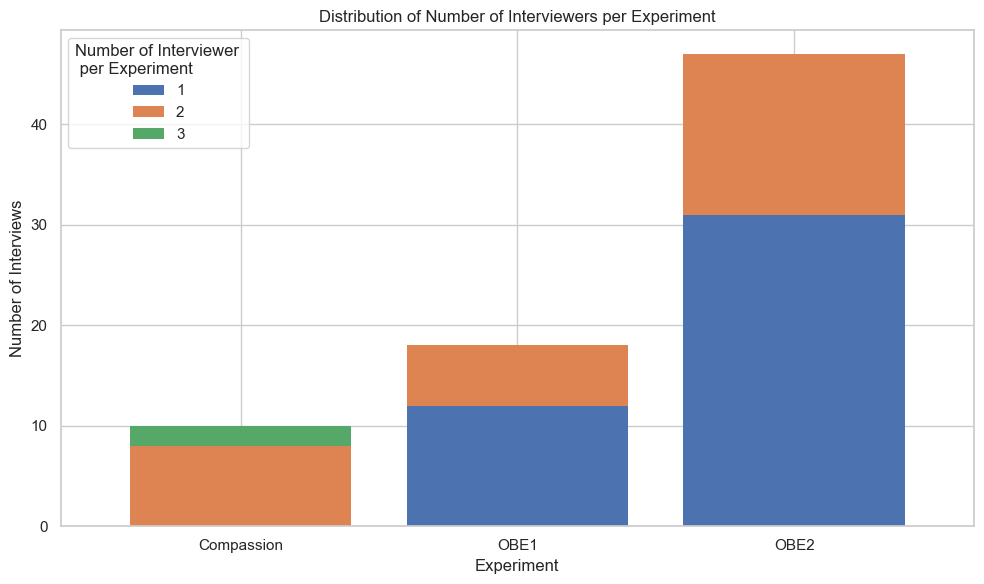

In [9]:
# Step 1: Drop participants and focus on interviewers
filtered_df = df_all[df_all["Speaker_original"].str.contains("Interviewer")]

# Step 2: Count unique interviewers per interview
experimenter_count = (filtered_df.groupby(['Experiment', 'File Name'])['Speaker_original'].nunique().reset_index())
experimenter_count.rename(columns={'Speaker_original': 'Number of Interviewers'}, inplace=True)

# Step 3: Aggregate counts for each experiment and interviewer category
experiment_summary = experimenter_count.groupby(['Experiment', 'Number of Interviewers'])['File Name'].count().reset_index()
experiment_summary.rename(columns={'File Name': 'Count'}, inplace=True)

# Step 4: Ensure all categories are represented
categories = list(range(1, experimenter_count['Number of Interviewers'].max() + 1))  # 1, 2, 3, etc.
all_experiments = experiment_summary['Experiment'].unique()
full_summary = pd.DataFrame(
    [(experiment, category) for experiment in all_experiments for category in categories],
    columns=['Experiment', 'Number of Interviewers']
).merge(experiment_summary, on=['Experiment', 'Number of Interviewers'], how='left').fillna(0)

# Convert counts to integers for clarity
full_summary['Count'] = full_summary['Count'].astype(int)

# Convert the Number of Interviewers to string for grouped bar chart
full_summary['Number of Interviewers'] = full_summary['Number of Interviewers'].astype(str)

# Step 5: Stacked bar chart
stacked_data = full_summary.pivot(index='Experiment', columns='Number of Interviewers', values='Count').fillna(0)
stacked_data.plot(kind='bar', stacked=True, figsize=(10, 6), width=0.8, linewidth=0)

# Add labels and title
plt.title("Distribution of Number of Interviewers per Experiment")
plt.ylabel("Number of Interviews")
plt.xlabel("Experiment")
plt.xticks(rotation=0)
plt.legend(title="Number of Interviewer \n per Experiment")

plt.tight_layout()
plt.savefig("images/number_of_interviewers_per_experiment.png")
plt.show()

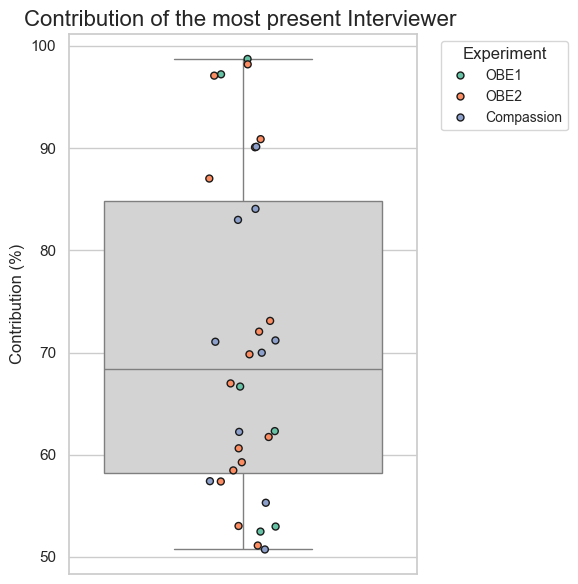

In [10]:
# Step 1: Filter for interviews with more than 1 interviewer
multi_interviewer_files = experimenter_count[experimenter_count['Number of Interviewers'] > 1]
filtered_df = filtered_df[filtered_df['File Name'].isin(multi_interviewer_files['File Name'])]

# Step 2: Calculate total word count per speaker per interview
word_distribution = filtered_df.groupby(['File Name', 'Speaker_original', 'Experiment'])['Word Count'].sum().reset_index()

# Step 3: Calculate dominance (largest contribution)
dominance = word_distribution.groupby(['File Name', 'Experiment'])['Word Count'].max().reset_index()
total_word_count = word_distribution.groupby(['File Name'])['Word Count'].sum().reset_index()
dominance = dominance.merge(total_word_count, on='File Name', how='left')
dominance['Dominance (%)'] = (dominance['Word Count_x'] / dominance['Word Count_y']) * 100
dominance.rename(columns={'Word Count_x': 'Max Contribution', 'Word Count_y': 'Total Words'}, inplace=True)

plt.figure(figsize=(6, 6))
sns.boxplot(data=dominance, y='Dominance (%)', color='lightgray')
sns.stripplot(data=dominance, y='Dominance (%)', hue="Experiment", jitter=True, edgecolor='k', linewidth=1, palette="Set2")

# Add titles and labels
plt.title("Contribution of the most present Interviewer ", fontsize=16)
plt.ylabel("Contribution (%)", fontsize=12)
# put legend outside of the plot
plt.legend(title="Experiment", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig("images/most_present_interviewer.png", dpi=600)
plt.show()

In [11]:
# Step 1: Filter out participants and focus on interviewers
filtered_df = df_all[df_all["Speaker_original"].str.contains("Interviewer")]

# Step 2: Count the number of unique interviewers for each interview
interviewer_counts = (filtered_df.groupby(['Id', 'File Name'])['Speaker_original'].nunique().reset_index())
interviewer_counts.rename(columns={'Speaker_original': 'Number of Interviewers'}, inplace=True)

# Step 3: Check changes in the number of interviewers for each participant (ID)
participant_interviewer_changes = (interviewer_counts.groupby('Id')['Number of Interviewers'].nunique().reset_index())
participant_interviewer_changes.rename(columns={'Number of Interviewers': 'Unique Interviewer Counts'}, inplace=True)

# Step 4: Identify participants with changes in interviewer counts across their interviews
participants_with_changes = participant_interviewer_changes[
    participant_interviewer_changes['Unique Interviewer Counts'] > 1
]

# Step 5: Display results
if participants_with_changes.empty:
    print("All participants have consistent numbers of interviewers across their interviews.")
else:
    print("The following participants have varying numbers of interviewers across their interviews:")
    print(participants_with_changes)

The following participants have varying numbers of interviewers across their interviews:
     Id  Unique Interviewer Counts
3    13                          2
9    19                          2
13   24                          2
17  204                          2
18  205                          2
20  207                          2
22  209                          2
31  220                          2
39  230                          2
41  302                          2


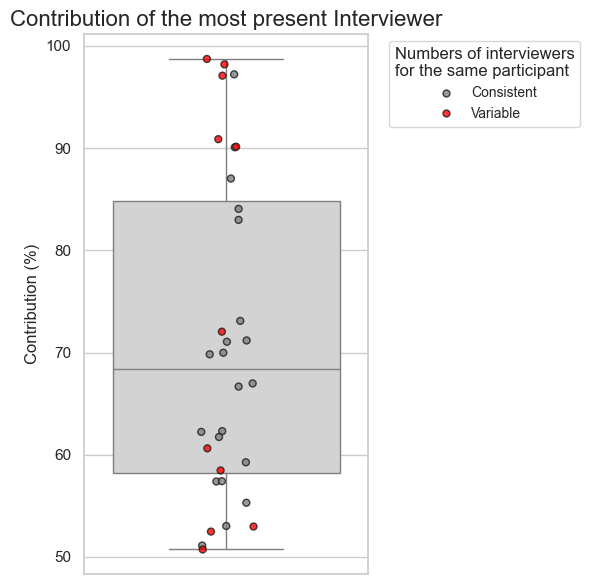

In [12]:
detailed_changes = interviewer_counts[interviewer_counts['Id'].isin(participants_with_changes['Id'])]
inconsistent_interviews = detailed_changes['File Name'].unique()  

# Add a new column to classify the points for hue
dominance['Highlight'] = dominance['File Name'].apply(lambda x: 'Variable' if x in inconsistent_interviews else 'Consistent')

plt.figure(figsize=(6, 6))
sns.boxplot(data=dominance, y='Dominance (%)', color='lightgray')

sns.stripplot( data=dominance, y='Dominance (%)', hue='Highlight', jitter=True, edgecolor='k', linewidth=1,  
                alpha=0.8, palette={'Variable': 'red', 'Consistent': 'gray'},)

plt.title("Contribution of the most present Interviewer", fontsize=16)
plt.ylabel("Contribution (%)", fontsize=12)
plt.legend(title="Numbers of interviewers\nfor the same participant", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.savefig("images/most_present_interviewer_inconsistent.png", dpi=600)
plt.show()

# Keyword Analysis

Before conducting the analysis, the following preprocessing steps were applied to ensure clean and meaningful text data:

- **Lowercasing:** Text was converted to lowercase.
- **Lemmatization:** Words were reduced to their base forms.
- **Stop-word Removal:** Both generic and custom stop words were removed to retain meaningful text.

The same analysis can be perform for the Interviewer text.

In [13]:
extra_stopwords = [
    # Filler Words: Common conversational placeholders without thematic value
    "yeah", "okay", "yes", "mean", "oh", "ah", "like","see",
    # Vague/Ambiguous Words: Frequent but thematically irrelevant in conversations
    "think", "know", "really", "bit", "feel", "thing", "sort", "maybe", "little"
]

# Remove from the default stopwords list (spacy)
retain_stopwords=["see", "yourself", "myself"]

df_participant['preprocessed_content'] = df_participant['Content'].apply(
                                    lambda x: preprocess_text(x, extra_stopwords=extra_stopwords,retain_stopwords=retain_stopwords))

## Words Frequency

Analyzes the most frequently used words across groups. Normalized frequencies ensure fair comparison, avoiding dominance by participants or groups with more text.

- **Identify Key Terms:** Highlights commonly used words within specific groups.
- **Compare Across Groups:** Provides insights into word usage by experiments or conditions.

### Word frequency by Experiement

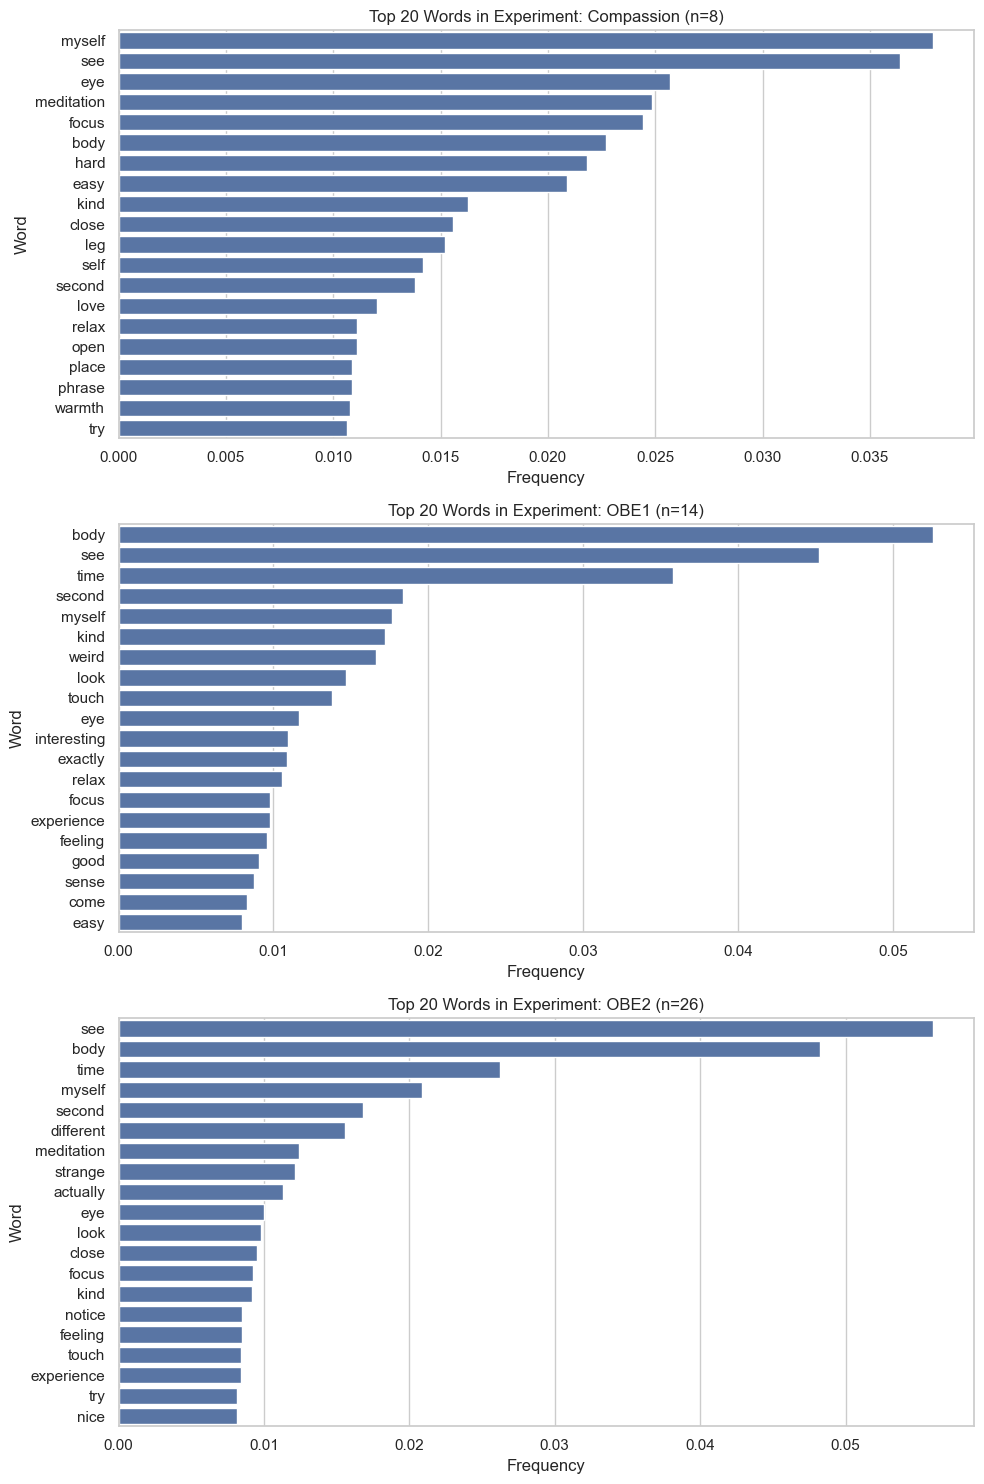

In [14]:
words_feq = count_word_frequencies(df_participant, groupby_columns=['Id','Experiment'], normalize=True)
plot_word_frequencies(words_feq, groupby_column='Experiment', level_column='Id')

### Word frequency by experiment & condition

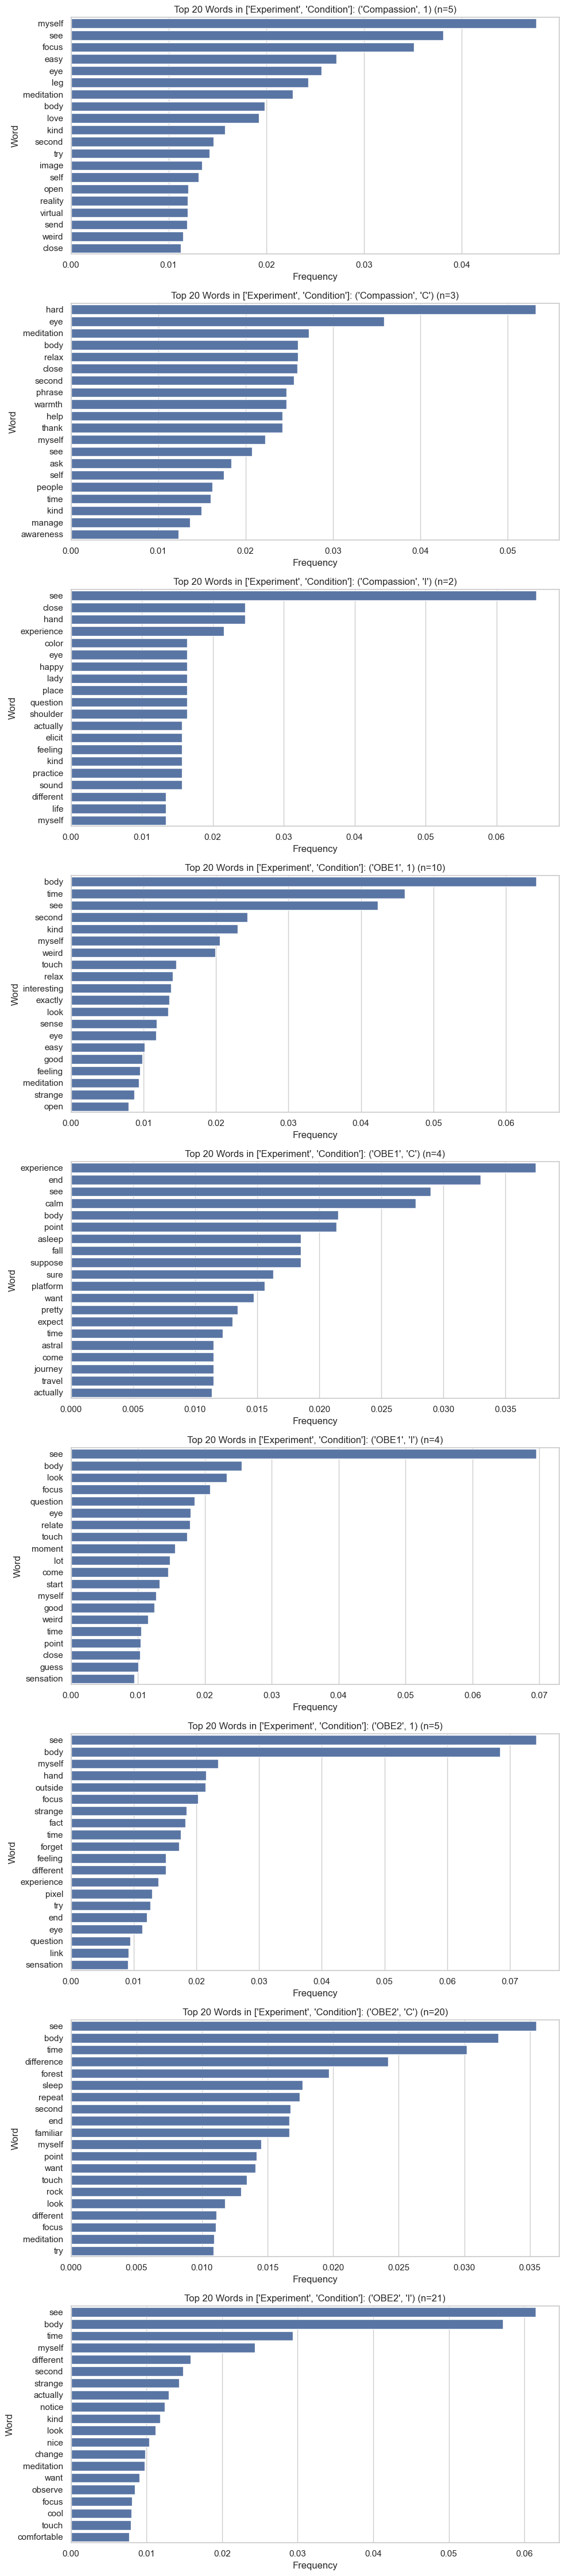

In [15]:
words_feq = count_word_frequencies(df_participant, groupby_columns=['File Name','Experiment','Condition'], normalize=True)
plot_word_frequencies(words_feq, groupby_column=['Experiment','Condition'], level_column='File Name')

## Shared participants uniques words 

This analysis identifies unique terms that are frequently shared among participants. Words that appear across multiple participants will be displayed larger in the visualizations, highlighting shared themes.

- **Explore Shared Content:** Provides an overview of common themes and topics shared by participants.
- **Comparison Across Groups:** Enables comparisons of shared content across different experiments and conditions

#### By Experiment

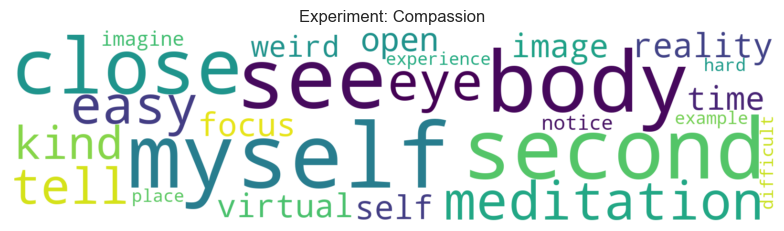

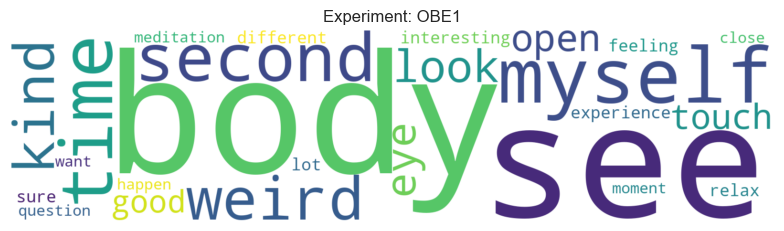

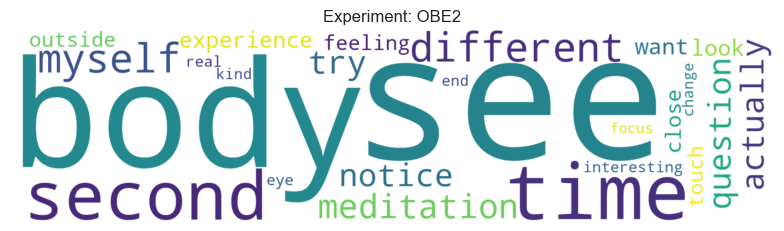

In [16]:
# You can specify any list of columns for grouping, e.g., ['Experiment', 'Condition']
unique_words_df_participant = count_unique_words(df_participant, groupby_columns=['Experiment'])
unique_words_df_participant = unique_words_df_participant.sort_values(by='Participant_Count', ascending=False)
#unique_words_df_participant.to_csv("outputs/unique_words_participant.csv", index=False)

generate_word_clouds(unique_words_df_participant, max_words=25, groupby_columns=['Experiment'])

#### By Condition

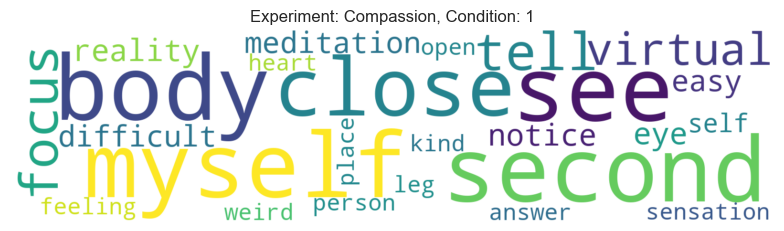

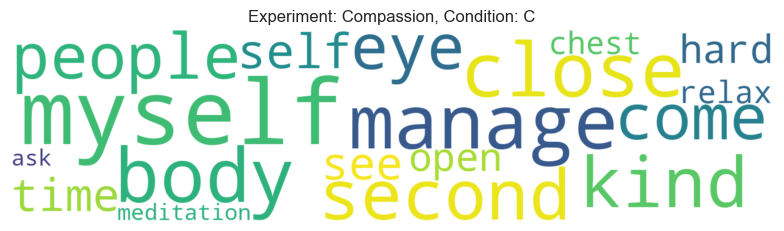

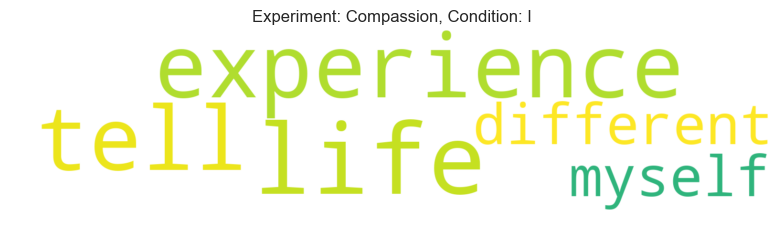

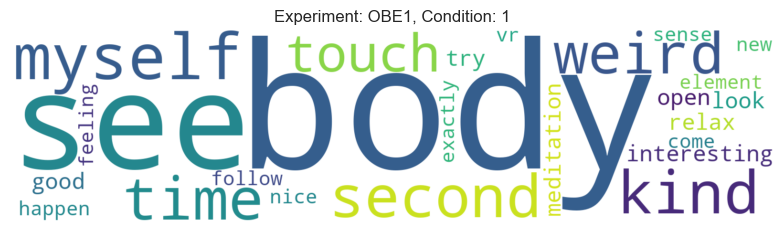

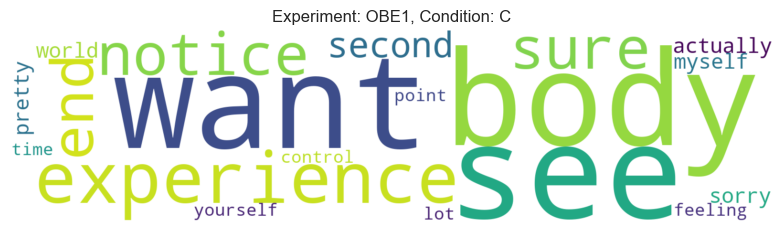

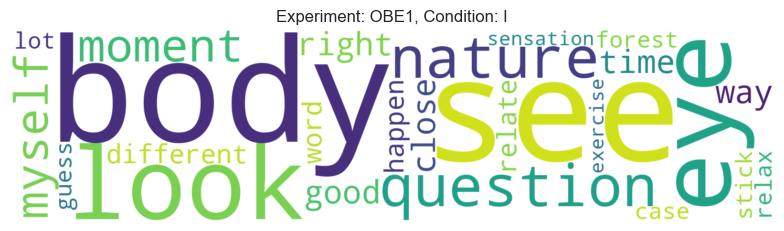

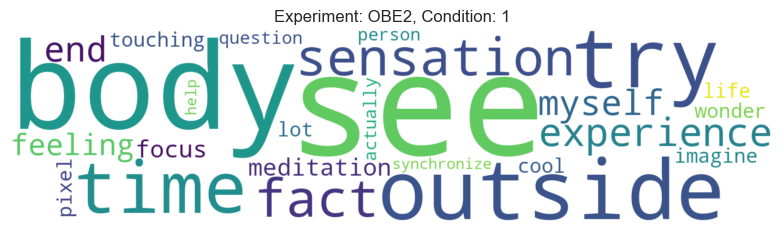

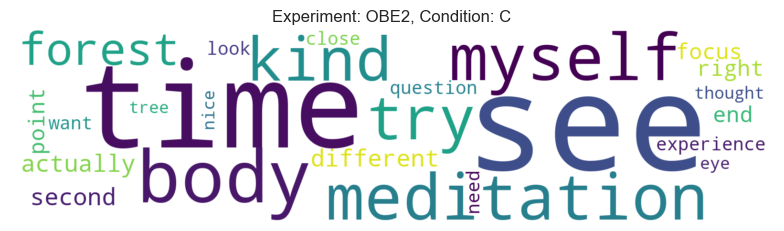

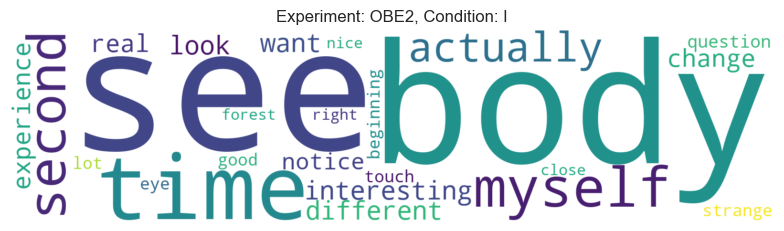

In [17]:
unique_words_df_participant = count_unique_words(df_participant, groupby_columns=['Experiment', 'Condition'])
unique_words_df_participant = unique_words_df_participant.sort_values(by='Participant_Count', ascending=False)
#unique_words_df_participant.to_csv("outputs/unique_words_participant.csv", index=False)

generate_word_clouds(unique_words_df_participant, max_words=25, groupby_columns=['Experiment',"Condition"])

### Merging OBE1 and OBE2

In [18]:
df_participant_merged_OBE = df_participant.copy()
df_participant_merged_OBE.Experiment = df_participant_merged_OBE.Experiment.replace({"OBE1": "OBE", "OBE2": "OBE"})

df_participant_merged_OBE.Experiment.unique()

array(['Compassion', 'OBE'], dtype=object)

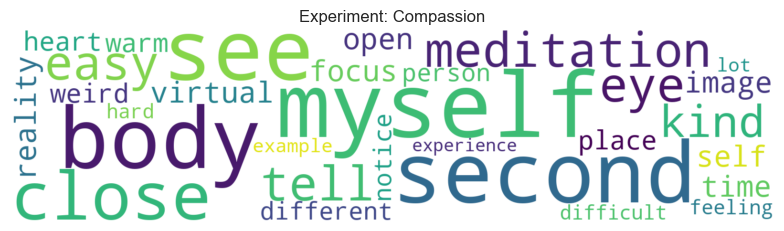

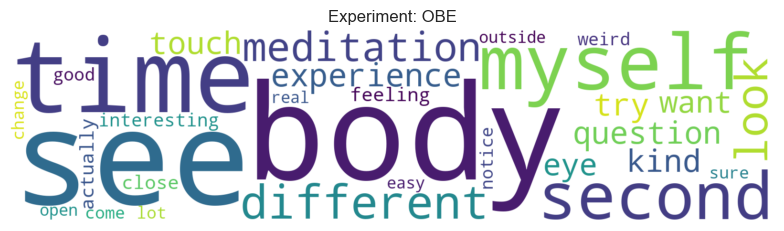

In [19]:
unique_words_df_participant = count_unique_words(df_participant_merged_OBE, groupby_columns=['Experiment'])
unique_words_df_participant = unique_words_df_participant.sort_values(by='Participant_Count', ascending=False)
#unique_words_df_participant.to_csv("outputs/unique_words_participant.csv", index=False)

generate_word_clouds(unique_words_df_participant, max_words=30, groupby_columns=['Experiment'], save_fig=True)

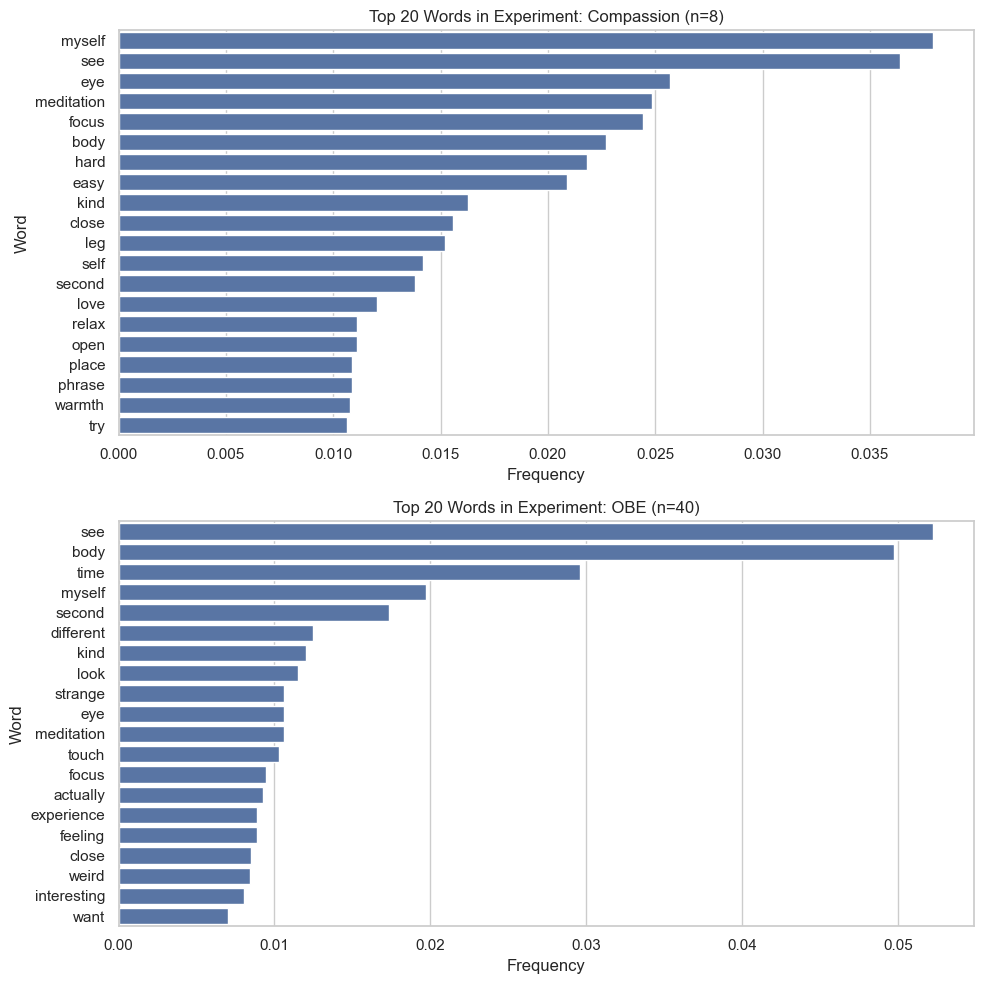

In [20]:
words_feq = count_word_frequencies(df_participant_merged_OBE, groupby_columns=['Id','Experiment'], normalize=True)
plot_word_frequencies(words_feq, groupby_column='Experiment', level_column='Id')